In [ ]:
# only run this cell once!
import os 
notebook_path = os.getcwd()
os.chdir(os.path.dirname(notebook_path))

In [4]:
import matplotlib.pyplot as plt
import numpy as np

# ploting style
import mplhep as hep
plt.style.use(hep.style.ATLAS)
# plt.rcParams['legend.loc'] = 'upper left'
figsize = (7, 7)
colors = plt.get_cmap('tab10')

# functions to process data
from performance.utils import process_csv_dir

c, gpu_data_instances = process_csv_dir("data/main_traccc_nom/")
c, gpu_init_all = process_csv_dir("data/main_traccc_init_everything/")
c, gpu_send = process_csv_dir("data/main_traccc_send/")
# c, gpu_send_recieve = process_csv_dir("data/send_and_recieve_headers/")
c, gpu_send_recieve = process_csv_dir("data/send_recieve_headers_2/")

TITLE = r"1 NVIDIA A100 SXM4 40GB, ODD detector, $\mu = 200$, traccc e7a03e9"

In [4]:
gpu_data_instances[1].keys()

Index(['Concurrency', 'Inferences/Second', 'Client Send',
       'Network+Server Send/Recv', 'Server Queue', 'Server Compute Input',
       'Server Compute Infer', 'Server Compute Output', 'Client Recv',
       'p50 latency', 'p90 latency', 'p95 latency', 'p99 latency',
       'request/response', 'response wait', 'Avg GPU Power Usage',
       'gpu_util_0', 'gpu_util_1', 'gpu_util_2', 'gpu_util_3',
       'gpu_memory_0_GB', 'gpu_memory_1_GB', 'gpu_memory_2_GB',
       'gpu_memory_3_GB', 'gpu_total_memory_0_GB', 'gpu_total_memory_1_GB',
       'gpu_total_memory_2_GB', 'gpu_total_memory_3_GB', 'total_gpu_usage',
       'max_gpu_memory', 'percent_gpu_memory'],
      dtype='object')

In [5]:
gpu_data_instances[1]

,Concurrency,Inferences/Second,Client Send,Network+Server Send/Recv,Server Queue,Server Compute Input,Server Compute Infer,Server Compute Output,Client Recv,p50 latency,...,gpu_memory_1_GB,gpu_memory_2_GB,gpu_memory_3_GB,gpu_total_memory_0_GB,gpu_total_memory_1_GB,gpu_total_memory_2_GB,gpu_total_memory_3_GB,total_gpu_usage,max_gpu_memory,percent_gpu_memory
0,1,5.97209,4,243,19,6,166993,96,1,164845,...,0.504365,0.504365,0.504365,42.949673,42.949673,42.949673,42.949673,48.0,4.044358,9.416504


In [5]:
def get_data(data):
    instances = []
    throughputs = []
    gpu_util = []
    gpu_memory_util = []
    latency = []
    network_server_send_recv = []
    request_response = []
    
    for inst in range(1,9):
        instances.append(inst)
        tmp_data = data[inst][data[inst]['Concurrency'] == inst]
        throughputs.append(tmp_data['Inferences/Second'].values[0])
        gpu_util.append(tmp_data['total_gpu_usage'].values[0])
        gpu_memory_util.append(tmp_data['percent_gpu_memory'].values[0])
        latency.append(tmp_data['p99 latency'].values[0] * 1e-3)
        network_server_send_recv.append(tmp_data['Network+Server Send/Recv'].values[0] * 1e-3)
        request_response.append(tmp_data['request/response'].values[0] * 1e-3)
        
    return instances, [throughputs, gpu_util, gpu_memory_util, latency, network_server_send_recv, request_response]

In [6]:
inst, variables = get_data(gpu_data_instances)
inst, vars_init_all_init_all = get_data(gpu_init_all)
inst, vars_send_recieve = get_data(gpu_send_recieve)
instances, vars_send = get_data(gpu_send)

ylabs = ["Throughput [events/s]", "GPU Utilization [%]", "GPU Memory Utilization [%]", "Latency [ms]", "Network+Server Send/Recv [ms]", "Request/Response [ms]"]

In [8]:
def plot_variable(instances, var, var_init_all, var_send, vars_send_recieve, ylabel):
    fig = plt.figure(figsize=figsize)
    plt.plot(instances, vars_send_recieve, label="Send Data, Recieve Headers", marker='o', color=colors(3))
    plt.plot(instances, var_send, label="Send Data", marker='o', color=colors(0))
    plt.plot(instances, var, label="Load Data at Server Initialization", marker='o', color=colors(1))
    plt.plot(instances, var_init_all, label="Load Data into Server GPU", marker='o', color=colors(2))
    plt.title(TITLE, loc='left', fontsize=12)
    plt.xlabel("Number of Triton Model Instances")
    plt.legend()
    plt.ylabel(ylabel)

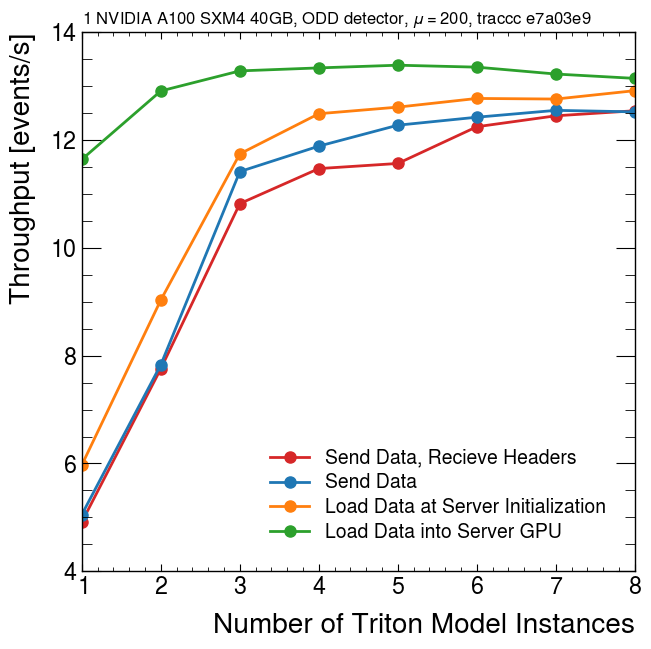

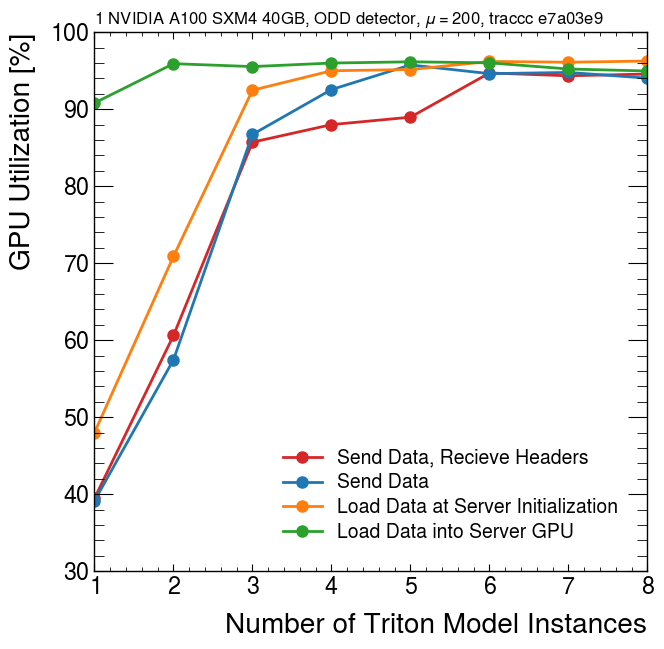

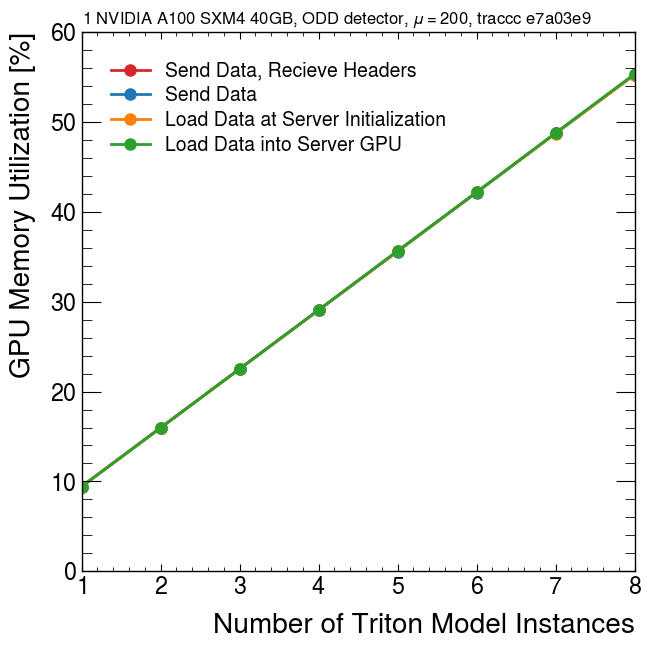

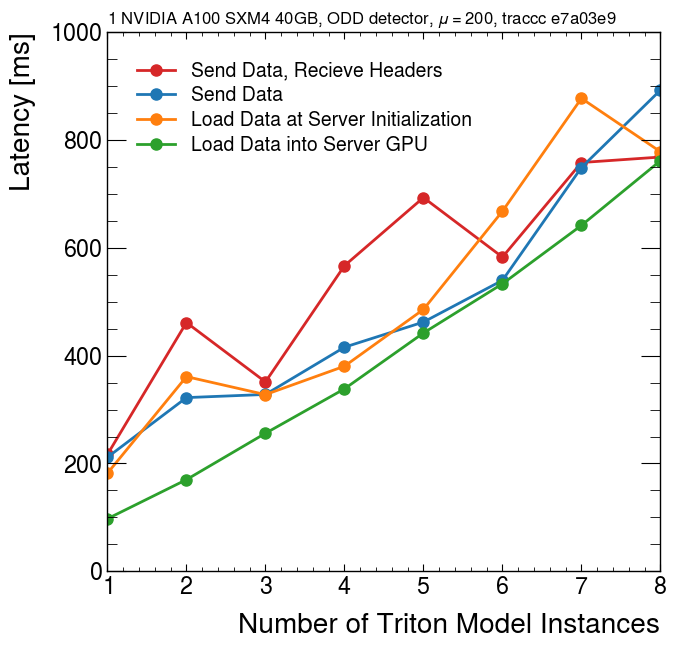

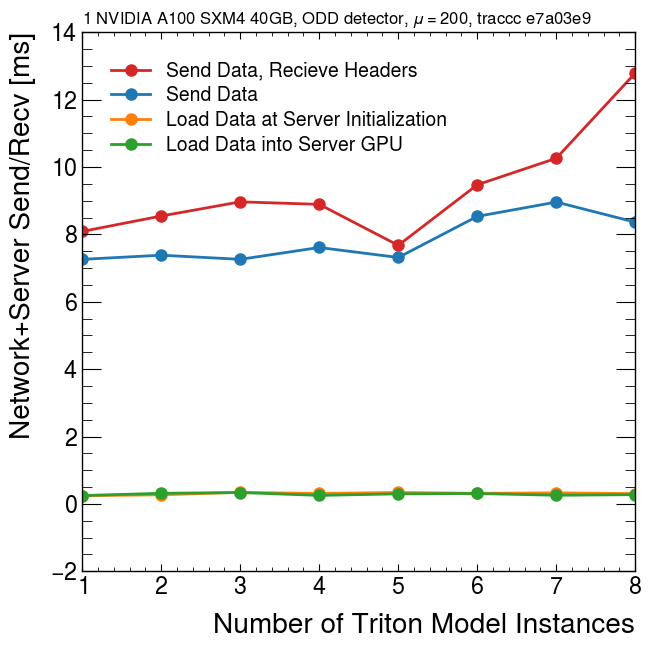

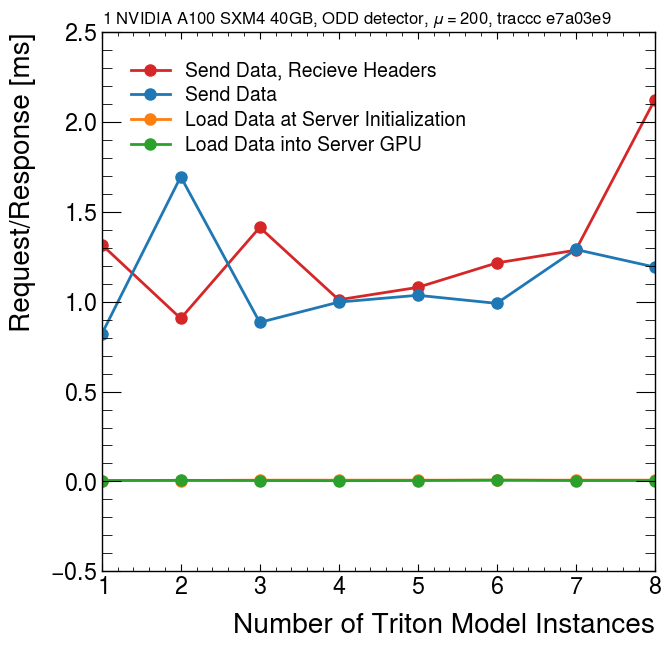

In [9]:
for lab in ylabs:
    plot_variable(inst, variables[ylabs.index(lab)], vars_init_all_init_all[ylabs.index(lab)], 
                  vars_send[ylabs.index(lab)], vars_send_recieve[ylabs.index(lab)], lab)
    plt.show()

In [7]:
# print average latency per request
latency_per_request = [l / inst for l, inst in zip(variables[3], instances)]
latency_per_request_init_all = [l / inst for l, inst in zip(vars_init_all_init_all[3], instances)]
latency_per_request_send = [l / inst for l, inst in zip(vars_send[3], instances)]

print("Average latency per request:")
print("Load Data at Server Initialization", np.average(latency_per_request), "+/-", np.std(latency_per_request))
print("Load Data into Server GPU", np.average(latency_per_request_init_all), "+/-", np.std(latency_per_request_init_all))
print("Send Data", np.average(latency_per_request_send), "+/-", np.std(latency_per_request_send))


Average latency per request:
Load Data at Server Initialization 124.72753154761905 +/- 33.88797497781545
Load Data into Server GPU 89.55701443452381 +/- 4.517167441833948
Send Data 123.354903125 +/- 39.12196606955122


In [9]:
vars_send[4]

[np.float64(7.259),
 np.float64(7.382000000000001),
 np.float64(7.259),
 np.float64(7.611),
 np.float64(7.314),
 np.float64(8.534)]

In [ ]:
print("Average latency per request:")
print("Load Data at Server Initialization", np.average(latency_per_request[5:7]), "+/-", np.std(latency_per_request[5:7]))
print("Load Data into Server GPU", np.average(latency_per_request_init_all[3:7]), "+/-", np.std(latency_per_request_init_all[3:7]))
print("Send Data", np.average(latency_per_request_send[3:7]), "+/-", np.std(latency_per_request_send[3:7]))

Average latency per request:
Load Data at Server Initialization 107.22897976190475 +/- 12.18057681051858
Load Data into Server GPU 88.38826845238094 +/- 2.520072447727503
Send Data 98.33450416666668 +/- 7.264733401856677
